# Guided-MT Code2Vec Evaluation

This Notebook runs over the experiment-outputs, extracts data and makes plots.

Expected Layout:

```
.
├── README.md
├── data
│   └── random-MRR-max
│       ├── seed-2880
│       │   ├── data
│       │   │   ├── gen0
│       │   │   │   ├── 3b2459
│       │   │   │   ├── 3b2459.json
│       │   │   │   ├── 447e22
│       │   │   │   ├── 447e22.json
│       │   │   │   ├── 4495c7
│       │   │   │   ├── 4495c7.json
│       │   │   │   ├── 52667b
│       │   │   │   ├── 52667b.json
│       │   │   │   ├── 6855ba
│       │   │   │   ├── 6855ba.json
│       │   │   │   ├── 68ec75
│       │   │   │   ├── 68ec75.json
│       │   │   │   ├── 6cc14d
│       │   │   │   ├── 6cc14d.json
│       │   │   │   ├── 6d6845
│       │   │   │   ├── 6d6845.json
│       │   │   │   ├── 7a2d67
│       │   │   │   ├── 7a2d67.json
│       │   │   │   ├── ed0dd9
│       │   │   │   └── ed0dd9.json
│       │   │   ├── gen1
│       │   │   ├── ...
│       │   │   ├── gen8
│       │   │   ├── ...
│       │   │   ├── generation_0
│       │   │   │   ├── Some.java
│       │   │   │   ├── ...
│       │   │   │   ├── Other.java
│       │   │   │   └── Different.java
│       │   │   └── initialGen
│       │   │       └── 3bf9ce
│       │   └── results.txt
│       ├── seed-5142
│           └── results.txt
│       ...
├── evaluation.ipynb
└── requirements.txt
```

## Data Loading

Most of this is done in the nearby extract script, but we also extract some highlevel variables.

In [1]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import extract

# Important: Specify Directory without / at the end!
directory:str = "./data"
# Whether only the most important plots will be made
verbose:bool = False

In [2]:
%%time
df = extract.make_df(directory)

found 5122 .json-files in ./data
CPU times: user 1.09 s, sys: 1.47 s, total: 2.56 s
Wall time: 4.63 s


In [3]:
all_metrics = ["F1","MRR","EDITDIST","PMRR","REC","PREC"]
all_transformers = extract.get_known_transformers()
all_experiments = set(df["experiment"])
all_seeds = set(df["seed"])

In [4]:
df.head(5)

,PREC,F1,hash_with_lifetime,MRR,genotype,REC,parent_2,parent_1,PMRR,EDITDIST,...,TRANSFORMATIONS,generation,algorithm,RenameVariableTransformer,IfFalseElseTransformer,AddNeutralElementTransformer,AddUnusedVariableTransformer,LambdaIdentityTransformer,IfTrueTransformer,RandomParameterNameTransformer
0,0.420344,0.502294,-1620537712,0.444992,"[{'seed': 8094572922318310914, 'transformer': ...",0.556849,"[{'seed': 8094572922318310914, 'transformer': ...","[{'seed': 8094572922318310914, 'transformer': ...",0.878193,0.535306,...,4,4,genetic,1,0,2,0,0,0,1
1,0.413260,0.508426,-1657229103,0.451554,"[{'seed': 8094572922318310914, 'transformer': ...",0.551445,"[{'seed': 8094572922318310914, 'transformer': ...","[{'seed': 8094572922318310914, 'transformer': ...",0.876125,0.528881,...,2,4,genetic,1,0,1,0,0,0,0
2,0.412116,0.508607,524757233,0.451587,"[{'seed': 8094572922318310914, 'transformer': ...",0.551829,"[{'seed': 8094572922318310914, 'transformer': ...","[{'seed': 8094572922318310914, 'transformer': ...",0.876179,0.529471,...,2,4,genetic,1,0,1,0,0,0,0
3,0.413000,0.507940,-1014986515,0.450592,"[{'seed': 8094572922318310914, 'transformer': ...",0.552352,"[{'seed': 8094572922318310914, 'transformer': ...","[{'seed': 8094572922318310914, 'transformer': ...",0.876809,0.529293,...,1,4,genetic,0,0,1,0,0,0,0
4,0.416519,0.505225,1773713408,0.446988,"[{'seed': 8094572922318310914, 'transformer': ...",0.554522,"[{'seed': 8094572922318310914, 'transformer': ...","[{'seed': 8094572922318310914, 'transformer': ...",0.877274,0.533475,...,3,4,genetic,1,0,2,0,0,0,0


In [5]:
df["algorithm"] = df.algorithm.astype("category")
#df["algorithm"]
df.dtypes



PREC                               float64
F1                                 float64
hash_with_lifetime                   int64
MRR                                float64
genotype                            object
REC                                float64
parent_2                            object
parent_1                            object
PMRR                               float64
EDITDIST                           float64
age                                  int64
hash                                 int64
introduced_generation                int64
path                                object
seed                              category
experiment                        category
TRANSFORMATIONS                      int64
generation                           int64
algorithm                         category
RenameVariableTransformer            int64
IfFalseElseTransformer               int64
AddNeutralElementTransformer         int64
AddUnusedVariableTransformer         int64
LambdaIdent

## Per Experiment Plots

In [6]:
#grouped_df = df.groupby(["experiment","generation","seed"]).mean().reset_index()
#grouped_df.head(5)

In [7]:
grouped_by_generation = df.groupby(["experiment","generation"]).mean().reset_index()
#Note: The grouping removes all fields that are not used for grouping or can be meaned,
#so we have to re-add algorithm
grouped_by_generation["algorithm"]=grouped_by_generation.experiment.apply(lambda x: "random" if "random" in x else "genetic")
grouped_by_generation.head(5)

/var/folders/_r/86rx32md65z38kxy53qvzz49b10v3m/T/ipykernel_3490/3662417048.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_generation = df.groupby(["experiment","generation"]).mean().reset_index()


,experiment,generation,PREC,F1,hash_with_lifetime,MRR,REC,PMRR,EDITDIST,age,...,introduced_generation,TRANSFORMATIONS,RenameVariableTransformer,IfFalseElseTransformer,AddNeutralElementTransformer,AddUnusedVariableTransformer,LambdaIdentityTransformer,IfTrueTransformer,RandomParameterNameTransformer,algorithm
0,F1-max,0,0.423094,0.495775,2.932414e+08,0.565047,0.565306,0.881154,0.543778,1.0,...,0.0,1.580000,0.190000,0.280000,0.220000,0.220000,0.220000,0.300000,0.150000,genetic
1,F1-max,1,0.434485,0.482954,4.271580e+08,0.579984,0.578505,0.885787,0.557418,1.0,...,1.0,2.544304,0.139241,0.594937,0.202532,0.405063,0.481013,0.531646,0.189873,genetic
2,F1-max,2,0.441517,0.473287,-7.577526e+07,0.590585,0.589235,0.889572,0.567408,1.0,...,2.0,4.303371,0.314607,0.820225,0.415730,0.584270,0.786517,0.988764,0.393258,genetic
3,F1-max,3,0.452053,0.461574,3.591533e+07,0.606016,0.601148,0.894093,0.581513,1.0,...,3.0,5.952941,0.482353,1.070588,0.470588,0.764706,1.305882,1.258824,0.600000,genetic
4,F1-max,4,0.455723,0.453672,-1.974192e+07,0.616447,0.610952,0.897316,0.590916,1.0,...,4.0,7.966667,0.822222,1.355556,0.822222,0.855556,1.833333,1.488889,0.788889,genetic


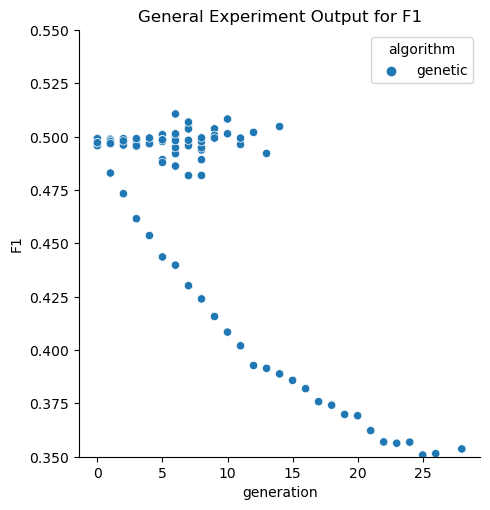

In [8]:
sbn.relplot(data=grouped_by_generation,x="generation",y="F1",hue="algorithm",facet_kws=dict(legend_out=False))
plt.ylim([0.35,0.55])
plt.title("General Experiment Output for F1")
plt.savefig("figures/general-generations-f1")
plt.show()

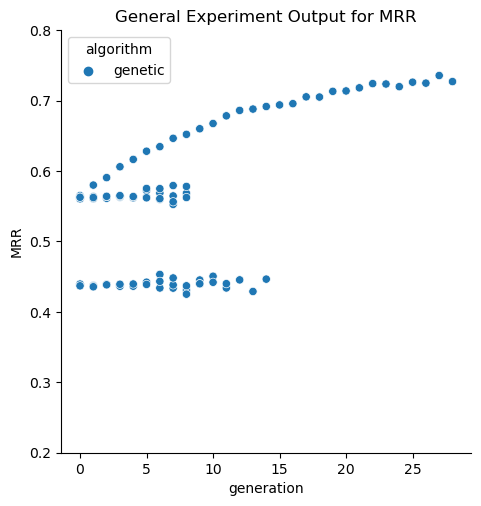

In [9]:
ax = sbn.relplot(data=grouped_by_generation,x="generation",y="MRR",hue="algorithm",
    facet_kws=dict(legend_out=False))
plt.ylim([0.2,0.8])
plt.title("General Experiment Output for MRR")
plt.savefig("figures/general-generations-mrr")
plt.show()

In [10]:
grouped_by_transformation =  df.groupby(["experiment","TRANSFORMATIONS"]).mean().reset_index()
#Note: The grouping removes all fields that are not used for grouping or can be meaned,
#so we have to re-add algorithm
grouped_by_transformation["algorithm"]=grouped_by_transformation.experiment.apply(lambda x: "random" if "random" in x else "genetic")
grouped_by_transformation.head(5)

/var/folders/_r/86rx32md65z38kxy53qvzz49b10v3m/T/ipykernel_3490/2676679882.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_transformation =  df.groupby(["experiment","TRANSFORMATIONS"]).mean().reset_index()


,experiment,TRANSFORMATIONS,PREC,F1,hash_with_lifetime,MRR,REC,PMRR,EDITDIST,age,...,introduced_generation,generation,RenameVariableTransformer,IfFalseElseTransformer,AddNeutralElementTransformer,AddUnusedVariableTransformer,LambdaIdentityTransformer,IfTrueTransformer,RandomParameterNameTransformer,algorithm
0,F1-max,1,0.420295,0.498015,1.817320e+08,0.562728,0.563448,0.880319,0.541307,1.0,...,0.437500,0.437500,0.062500,0.234375,0.031250,0.125000,0.218750,0.265625,0.062500,genetic
1,F1-max,2,0.428983,0.489079,2.251576e+08,0.572153,0.572233,0.883451,0.550273,1.0,...,0.736364,0.736364,0.154545,0.345455,0.254545,0.300000,0.336364,0.490909,0.118182,genetic
2,F1-max,3,0.434804,0.483342,2.883799e+08,0.578936,0.577761,0.886074,0.556306,1.0,...,1.625000,1.625000,0.093750,0.500000,0.281250,0.718750,0.468750,0.593750,0.343750,genetic
3,F1-max,4,0.444858,0.471620,-1.392042e+08,0.593201,0.589964,0.890257,0.569215,1.0,...,2.264706,2.264706,0.235294,0.500000,0.323529,0.764706,0.823529,0.794118,0.558824,genetic
4,F1-max,5,0.445071,0.467463,4.698844e+08,0.599664,0.596089,0.892261,0.575813,1.0,...,2.627451,2.627451,0.352941,1.039216,0.333333,0.725490,1.078431,1.078431,0.392157,genetic


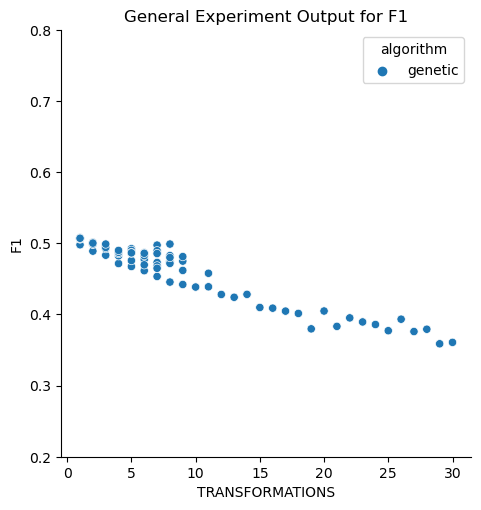

In [11]:
ax = sbn.relplot(data=grouped_by_transformation,x="TRANSFORMATIONS",y="F1",hue="algorithm",
    facet_kws=dict(legend_out=False))
plt.ylim([0.2,0.8])
plt.title("General Experiment Output for F1")
plt.savefig("figures/general-transformations-f1")
plt.show()

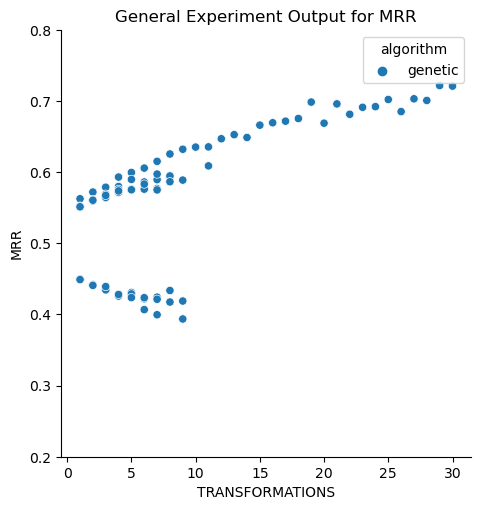

In [12]:
ax = sbn.relplot(data=grouped_by_transformation,x="TRANSFORMATIONS",y="MRR",hue="algorithm",
    facet_kws=dict(legend_out=False))
plt.ylim([0.2,0.8])
plt.title("General Experiment Output for MRR")
plt.savefig("figures/general-transformations-mrr")
plt.show()


In [13]:
if verbose:
    for exp in all_experiments:
        ax = sbn.relplot(data=grouped_by_generation[grouped_by_generation["experiment"]==exp],x="generation",y="F1",kind="line")
        plt.title(f"F1 Score for {exp}")
        plt.xlabel("Generation")
        plt.ylabel("F1")
        plt.ylim([0,1])
        plt.show()

    for exp in all_experiments:
        sbn.relplot(data=grouped_by_generation[grouped_by_generation["experiment"]==exp],x="generation",y="MRR",kind="line")
        plt.title(f"MRR Score for {exp}")
        plt.xlabel("Generation")
        plt.ylabel("MRR")
        plt.ylim([0,1])
        plt.show()

/var/folders/_r/86rx32md65z38kxy53qvzz49b10v3m/T/ipykernel_3490/1239390605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["experiment"]=filtered_df.experiment.astype(str)


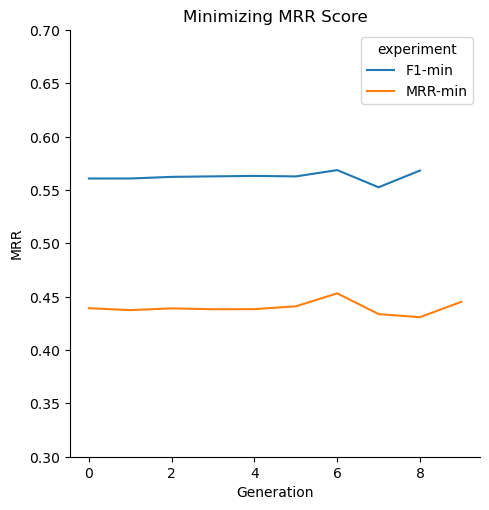

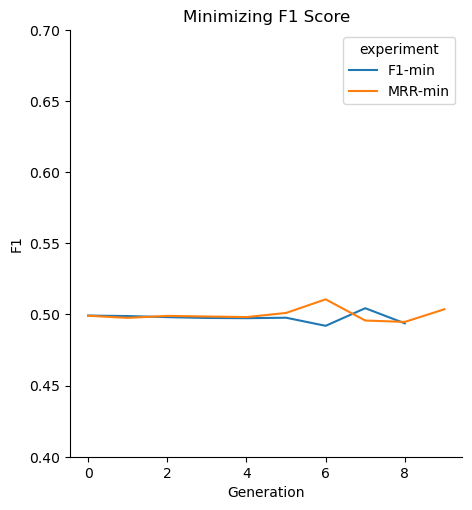

In [14]:
# Combi-Plots

combinations = ["F1-min","MRR-min","random-F1-min","random-MRR-min"]
mask = grouped_by_generation["experiment"].isin(combinations)
filtered_df = grouped_by_generation[mask]
filtered_df["experiment"]=filtered_df.experiment.astype(str)


sbn.relplot(data=filtered_df,x="generation",y="MRR",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.3,0.7])
plt.xlabel("Generation")
plt.ylabel("MRR")
plt.title("Minimizing MRR Score")
plt.savefig("figures/minimizing-mrr")
plt.show()


sbn.relplot(data=filtered_df,x="generation",y="F1",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.4,0.7])
plt.xlabel("Generation")
plt.ylabel("F1")
plt.title("Minimizing F1 Score")
plt.savefig("figures/minimizing-f1")
plt.show()

del mask,filtered_df,combinations

/var/folders/_r/86rx32md65z38kxy53qvzz49b10v3m/T/ipykernel_3490/2283309158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["experiment"]=filtered_df.experiment.astype(str)


<Figure size 100x100 with 0 Axes>

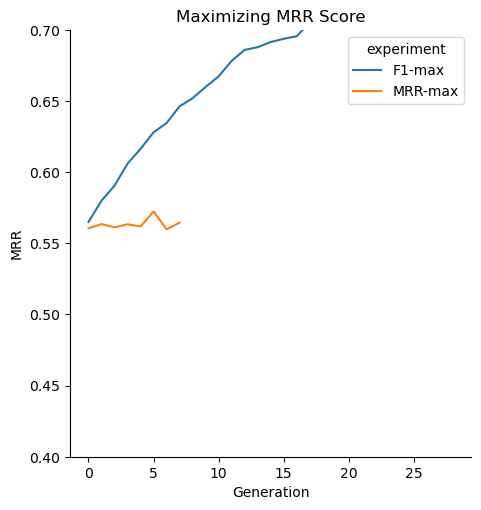

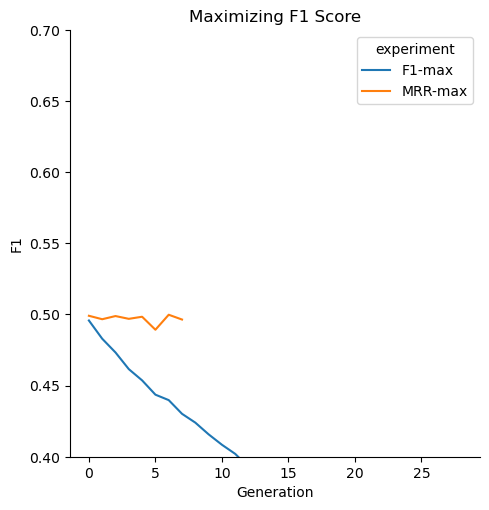

In [15]:
# Combi-Plots

combinations = ["F1-max","MRR-max","random-F1-max","random-MRR-max"]
mask = grouped_by_generation["experiment"].isin(combinations)
filtered_df = grouped_by_generation[mask]
filtered_df["experiment"]=filtered_df.experiment.astype(str)


plt.figure(figsize=(1,1))
sbn.relplot(data=filtered_df,x="generation",y="MRR",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.4,0.7])
plt.xlabel("Generation")
plt.title("Maximizing MRR Score")
plt.ylabel("MRR")
plt.savefig("figures/maximizing-mrr")
plt.show()


sbn.relplot(data=filtered_df,x="generation",y="F1",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.4,0.7])
plt.xlabel("Generation")
plt.ylabel("F1")
plt.title("Maximizing F1 Score")
plt.savefig("figures/maximizing-f1")
plt.show()

del mask,filtered_df,combinations

### Pareto Tradeoffs

/var/folders/_r/86rx32md65z38kxy53qvzz49b10v3m/T/ipykernel_3490/1226702029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["experiment"]=filtered_df.experiment.astype(str)


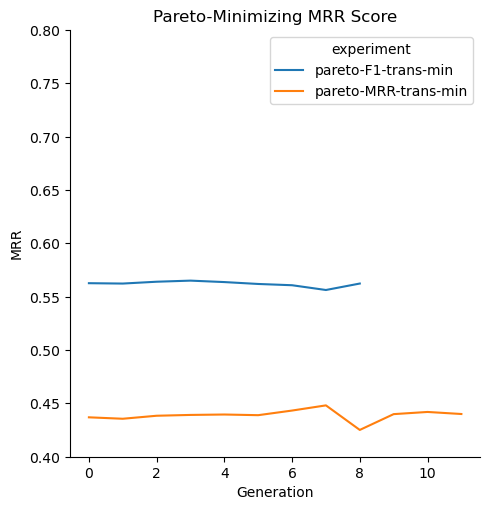

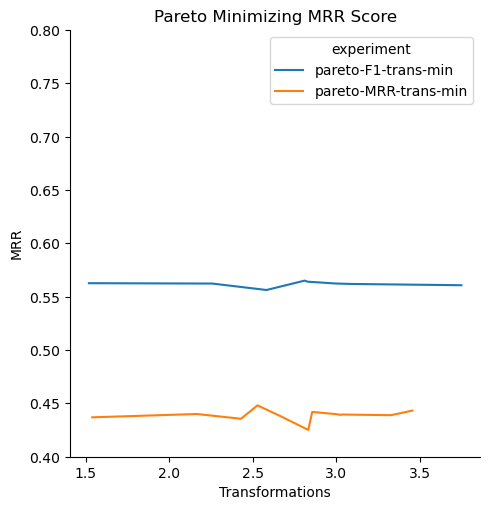

In [16]:
combinations = ["pareto-F1-trans-min","pareto-MRR-trans-min","random-pareto-F1-trans-min","random-pareto-MRR-trans-min"]
mask = grouped_by_generation["experiment"].isin(combinations)
filtered_df = grouped_by_generation[mask]
filtered_df["experiment"]=filtered_df.experiment.astype(str)

sbn.relplot(data=filtered_df,x="generation",y="MRR",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.4,0.8])
plt.xlabel("Generation")
plt.ylabel("MRR")
plt.title("Pareto-Minimizing MRR Score")
plt.savefig("figures/pareto-minimizing-mrr")
plt.show()

sbn.relplot(data=filtered_df,x="TRANSFORMATIONS",y="MRR",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.4,0.8])
plt.xlabel("Transformations")
plt.ylabel("MRR")
plt.title("Pareto Minimizing MRR Score")
plt.savefig("figures/pareto-minimizing-mrr-2")
plt.show()

del mask,filtered_df,combinations


/var/folders/_r/86rx32md65z38kxy53qvzz49b10v3m/T/ipykernel_3490/2831292213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["experiment"]=filtered_df.experiment.astype(str)


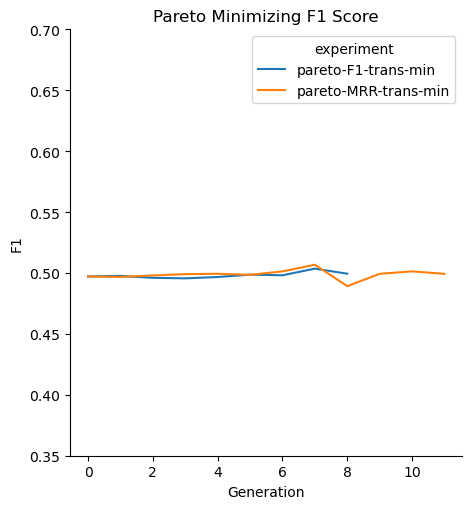

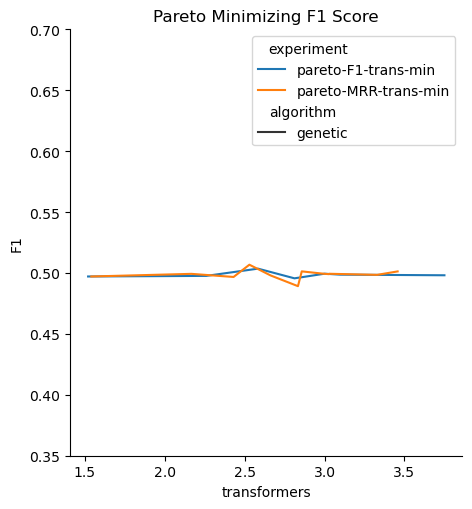

In [17]:
combinations = ["pareto-F1-trans-min","pareto-MRR-trans-min","random-pareto-F1-trans-min","random-pareto-MRR-trans-min"]
mask = grouped_by_generation["experiment"].isin(combinations)
filtered_df = grouped_by_generation[mask]
filtered_df["experiment"]=filtered_df.experiment.astype(str)

sbn.relplot(data=filtered_df,x="generation",y="F1",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.35,0.7])
plt.xlabel("Generation")
plt.ylabel("F1")
plt.title("Pareto Minimizing F1 Score")
plt.savefig("figures/pareto-minimizing-f1")
plt.show()


sbn.relplot(data=filtered_df,x="TRANSFORMATIONS",y="F1",style="algorithm",hue="experiment",kind="line",facet_kws=dict(legend_out=False))
plt.ylim([0.35,0.7])
plt.xlabel("transformers")
plt.ylabel("F1")
plt.title("Pareto Minimizing F1 Score")
plt.savefig("figures/pareto-minimizing-f1-2")
plt.show()

del mask,filtered_df,combinations


Text(0.5, 1.0, 'Distribution Generations vs. Transformations')

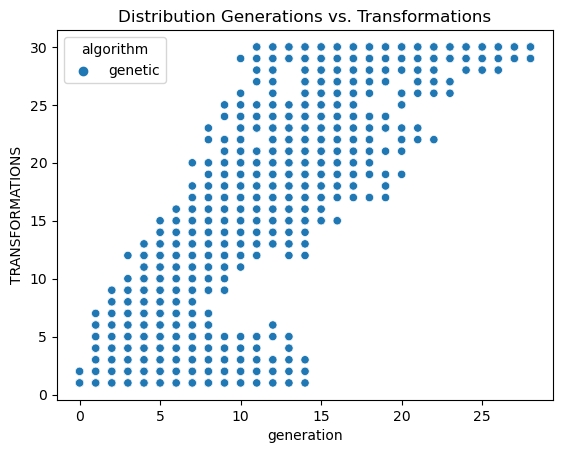

In [18]:
sbn.scatterplot(data=df,x="generation",y="TRANSFORMATIONS",hue="algorithm")
plt.title("Distribution Generations vs. Transformations")

In [19]:
sub_df = df[["experiment","TRANSFORMATIONS"]+all_transformers]
agg_transformations = sub_df.groupby(["experiment","TRANSFORMATIONS"]).sum().reset_index()

/Users/lapplis/opt/anaconda3/envs/guided-mt-evaluation/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lapplis/opt/anaconda3/envs/guided-mt-evaluation/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lapplis/opt/anaconda3/envs/guided-mt-evaluation/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is depreca

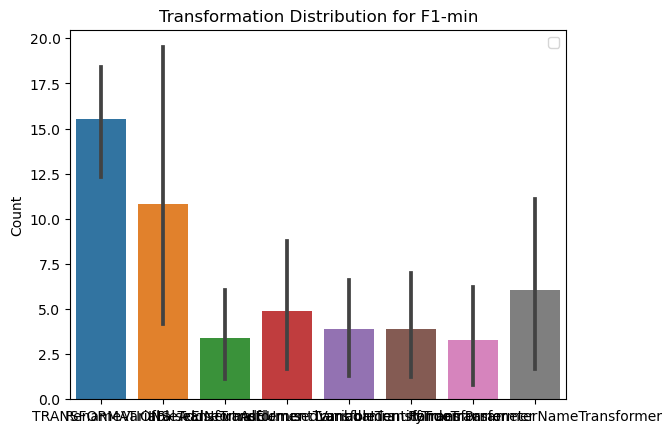

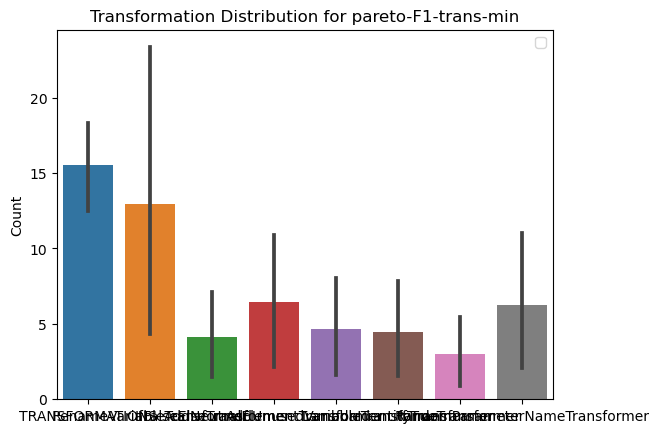

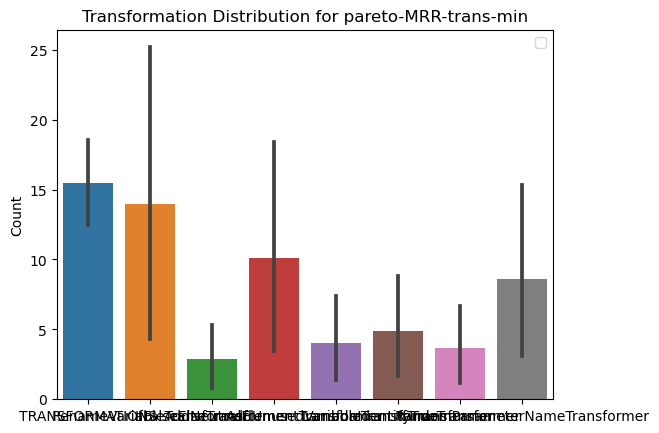

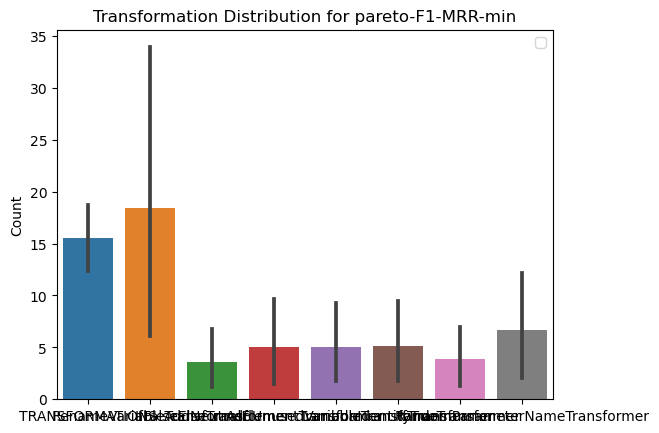

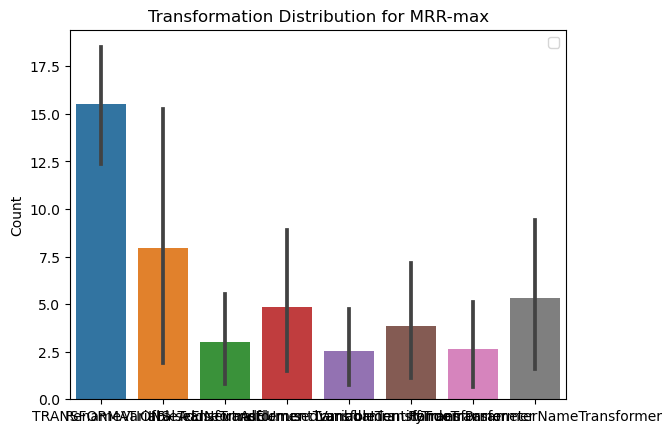

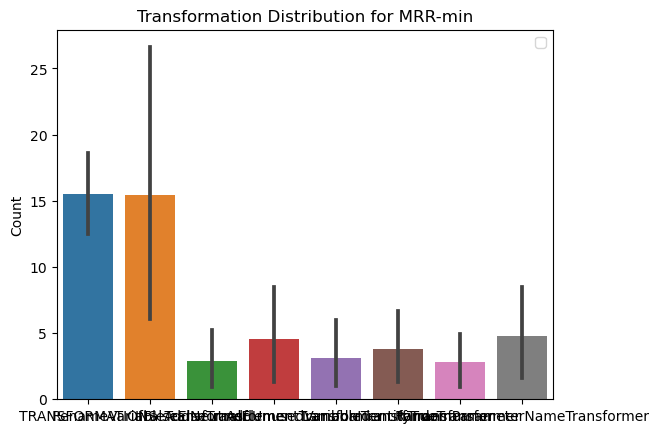

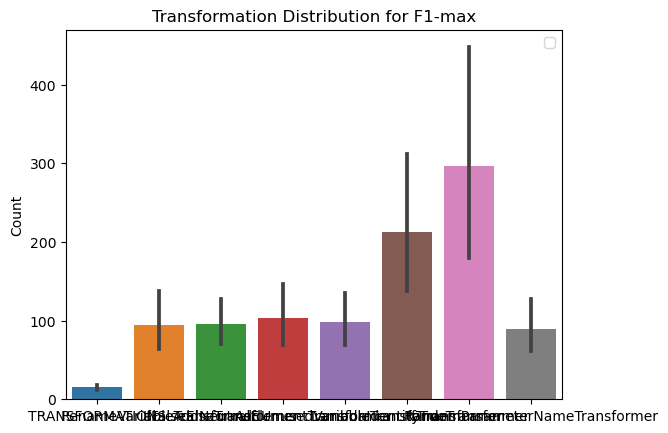

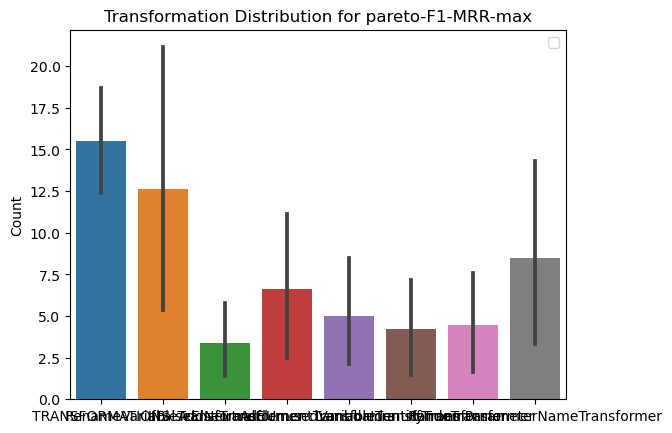

In [20]:
for exp in all_experiments:
    sbn.barplot(data=agg_transformations[agg_transformations["experiment"]==exp])
    plt.legend()
    plt.ylabel("Count")
    plt.title(f"Transformation Distribution for {exp}")
    plt.show()